In [32]:
#sgillen: implementation of trajectory optimization using the five link walker

# jupyter magic 
#==============================================================================

#%load_ext line_profiler

#%lprun -f __main__ __main__()

# imports
#==============================================================================

import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger, 
                         Isometry3, DirectCollocation, PiecewisePolynomial, VectorSystem)
from pydrake.solvers.mathematicalprogram import Solve

from pydrake.attic.multibody.shapes import VisualElement, Box
from pydrake.attic.multibody.collision import CollisionElement
import pydrake.symbolic as sym



#from pydrake.all import 
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML
import matplotlib.pyplot as plt

#this one is home grown, make sure it's in the same directory as this notebook
from seagul.drake import x_expr_prism,y_expr_prism,x_float_prism,y_float_prism, x_taylor_prism,y_taylor_prism
from seagul.resources import getResourcePath 
from numpy import pi

#set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link_prism.urdf"), FloatingBaseType.kFixed)

box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")

tree.compile()

plant = RigidBodyPlant(tree)
context = plant.CreateDefaultContext()

# set up the mathematical program , in this case direct collocation
#==============================================================================

num_time_samples = 21
dircol = DirectCollocation(plant, context, num_time_samples = num_time_samples,
                           minimum_timestep=0.05, maximum_timestep=0.05)

#add constraints
#------------------------------------------------------------------------------
#dircol.AddEqualTimeIntervalsConstraints()

dircol.AddLinearConstraint(dircol.initial_state()[0+2] - pi == -(dircol.final_state()[0+2] - pi))
dircol.AddLinearConstraint(dircol.initial_state()[1+2] ==  -dircol.final_state()[4+2])
dircol.AddLinearConstraint((dircol.initial_state()[0+2] + dircol.initial_state()[1+2] + dircol.initial_state()[2+2]) ==  (dircol.final_state()[0+2] + dircol.final_state()[1+2] + dircol.final_state()[2+2]))
dircol.AddLinearConstraint(2*pi - dircol.initial_state()[3+2] == dircol.final_state()[3+2])
dircol.AddLinearConstraint(dircol.initial_state()[4+2] == -dircol.final_state()[1+2])


# TODO Figure out the impact 
dircol.AddLinearConstraint(dircol.initial_state()[5+2]  == -(dircol.final_state()[5+2]))
dircol.AddLinearConstraint(dircol.initial_state()[6+2] ==  - dircol.final_state()[6+2])
dircol.AddLinearConstraint(dircol.initial_state()[7+2] + dircol.initial_state()[6+2] + dircol.initial_state()[5+2] == dircol.final_state()[7+2] + dircol.initial_state()[6+2] + dircol.initial_state()[5+2])
dircol.AddLinearConstraint(dircol.initial_state()[8+2] == - dircol.final_state()[8+2])
dircol.AddLinearConstraint(dircol.initial_state()[9+2] == -dircol.final_state()[9+2])

#there is probably a way to have rigid body tree calculate these quantities, but when I tried it did not work at all and this was pretty fast...
x5_in = x_expr_prism(dircol.initial_state())
x5_fn = x_expr_prism(dircol.final_state())

y5_in = y_expr_prism(dircol.initial_state())
y5_fn = y_expr_prism(dircol.final_state())


dircol.AddConstraint(x5_in <= -1)
dircol.AddConstraint(x5_fn >= 1)

dircol.AddConstraint(y5_fn == 0)
dircol.AddConstraint(y5_in == 0)

dircol.AddConstraint(dircol.initial_state()[0] == 0)
dircol.AddConstraint(dircol.initial_state()[1] == 0)
dircol.AddConstraint(dircol.final_state()[1] == 0)
dircol.AddConstraint(dircol.final_state()[0] == dircol.initial_state()[0])






for i in range(0,num_time_samples):
    dircol.AddConstraint(y_expr_prism(dircol.state(i)) >= 0)
    dircol.AddConstraint(dircol.state(i)[1] == 0)
    dircol.AddConstraint(sym.cos(dircol.state(i)[2]) + sym.cos(dircol.state(i)[2] + dircol.state(i)[3]) <= 0)

#Add costs
#------------------------------------------------------------------------------

R = 10  # Cost on input "effort".
u = dircol.input()

dircol.AddRunningCost(R*u[0]**2)
dircol.AddRunningCost(R*u[1]**2)
dircol.AddRunningCost(R*u[2]**2)
dircol.AddRunningCost(R*u[3]**2)

for i in range(0,num_time_samples):
    dircol.AddCost(-4*(y_taylor_prism(dircol.state(i), 4) - .2))
    
dircol.AddFinalCost(dircol.time())

#Add initial trajectory for the solver
#------------------------------------------------------------------------------

initial_state = (0, 0, pi - pi/8,    0 , -3*pi/4 - (pi - pi/8) ,  2*pi -( pi/2 + pi/4), 0, 0,0, 0, 0, 0, 0 ,0)  # initial condition
final_state =   (0, 0, pi + pi/8,    0 , -3*pi/4 - (pi + pi/8),  3*pi/4 ,0, 0, 0, 0, 0, 0, 0, 0)  # final condition

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)


#solve the nonlinear program
#==============================================================================

result = Solve(dircol)
if result.is_success():
    print("solver converged")
else:
    print("solver failed to converge")
    
#assert(result == SolutionResult.kSolutionFound)


# define variables later cells will use to acess the trajectory
#==============================================================================

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
times_index = [i for i in range(times.shape[0])]

u_lookup = np.vectorize(u_trajectory.value)
u_values = np.zeros((times.size,4),float)
for i,t in enumerate(times):
    u_values[i,:] = np.transpose(u_lookup(t))

x_trajectory = dircol.ReconstructStateTrajectory(result)
x_lookup = np.vectorize(x_trajectory.value)
x_values = np.zeros((times.size,14),float)
for i,t in enumerate(times):
    x_values[i,:] = np.transpose(x_lookup(t))

solver converged


False
-0.0016573770421321465
False
-1.7799143838004499


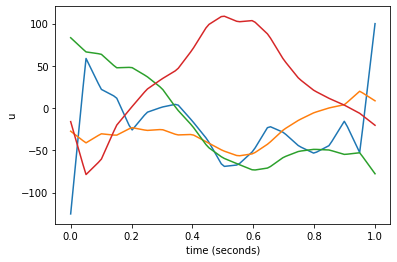

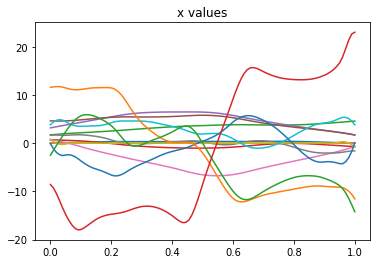

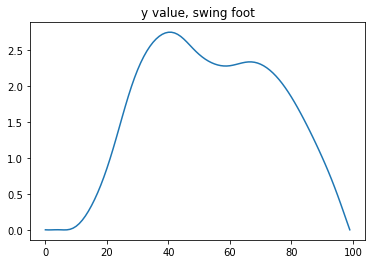

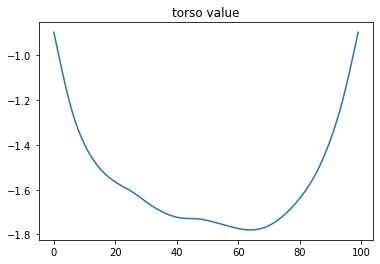

In [33]:
# plot the results
#==============================================================================

    
plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('u')

plt.figure()
plt.plot(times, x_values)
plt.title('x values')


y_vals = np.empty([100])
torso_vals = np.empty([100])


for i,time in enumerate(times):
    #print(x_trajectory.value(time))
    #print(y_float(x_trajectory.value(time)))
    #y_vals.append(y_float(x_trajectory.value(time)))
    y_vals[i] = y_float_prism(x_trajectory.value(time))
    torso_vals[i] = math.cos(x_trajectory.value(time)[2]) + math.cos(x_trajectory.value(time)[2] + x_trajectory.value(time)[3])

plt.figure()
plt.plot(y_vals)
plt.title('y value, swing foot')
print(all(i >= 0 for i in y_vals))
print(min(y_vals))

plt.figure()
plt.plot(torso_vals)
plt.title('torso value')
print(all(i >= 0 for i in torso_vals))
print(min(torso_vals))


prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
ani = prbv.animate(x_trajectory, resample=100, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())

